# multiway CCA
This notebook contains testing code for multi-way CCA based learning using a parafac tensor decomposition in the algorithm core, rather than a SVD

In [1]:
import numpy as np
from mindaffectBCI.decoder.offline.datasets import get_dataset
import mindaffectBCI.decoder.offline.load_mindaffectBCI 
from mindaffectBCI.decoder.model_fitting import MultiCCA
from mindaffectBCI.decoder.decodingCurveSupervised import decodingCurveSupervised
from mindaffectBCI.decoder.utils import block_permute
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from mindaffectBCI.decoder.analyse_datasets import analyse_dataset, analyse_datasets, debug_test_dataset, debug_test_single_dataset
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures
savefile=None

In [2]:
def plotCxy(Cxy, evtlabs=None, fs=None):
    times = np.arange(Cxy.shape[-2])
    if fs is not None: times = times/fs
    fit,ax = plt.subplots(nrows=1,ncols=Cxy.shape[1],sharey='row')
    for ei in range(Cxy.shape[1]):
        plt.sca(ax[ei])
        plt.imshow(Cxy[0,ei,:,:],aspect='auto',extent=[times[0],times[-1],0,Cxy.shape[-1]])
        if evtlabs is not None: plt.title(evtlabs[ei])

Load the data -- from dataset
-------------

In [ ]:
# load example data
dataset_loader, files, dataroot = get_dataset('plos_one', regexp='s3')
savefile = files[-1]

In [ ]:
# level threshold - single outputs with multiple levels
dataset_loader, files, dataroot = get_dataset('mindaffectBCI',exptdir="~/Desktop/khash",regexp='vep_threshold')
savefile = files[-1]

In [ ]:
# visual - acuity - multiple outputs at the same time.
dataset_loader, files, dataroot = get_dataset('mindaffectBCI',exptdir="~/Desktop/mark",regexp='vep_threshold_scale')
savefile = files[-1]

In [ ]:
# visual - acuity - multiple outputs at the same time.
dataset_loader, files, dataroot = get_dataset('mindaffectBCI',exptdir="~/Desktop/mark",regexp='visual_acuity')
savefile = files[-1]

Load the data -- ask user
------

In [3]:
if savefile is None:
    %gui tk
    from tkinter import Tk
    from tkinter.filedialog import askopenfilename
    import os
    root = Tk()
    root.withdraw()
    savefile = askopenfilename(initialdir=os.getcwd(),
                                title='Chose mindaffectBCI save File',
                                filetypes=(('mindaffectBCI','mindaffectBCI*.txt'),('All','*.*')))
    dataset_loader = mindaffectBCI.decoder.offline.load_mindaffectBCI.load_mindaffectBCI

Set the type of events to use and response length parameters based on the experiment type

In [4]:
dataset_args=dict(stopband=((45,65),(3,25,'bandpass')),out_fs=100)
tau_ms=550
offset_ms=100
evtypes=('re','fe')

# dataset specific pre-processing args
if 'threshold' in savefile:
    # model a different response for each level
    evttypes='hot-on'
    tau_ms = 550
    
elif 'visual_acuity' in savefile:
    # model a different response for each output = each cell in the stimulus matrix
    evttypes='output2event'
    tau_ms = 550
    
elif 'face_detection' in savefile:
    # model different response for each level
    evttypes=('>0','>4','>6','>8')
    tau_ms = 350
    offset_ms = 0
    dataset_args=dict(stopband=((45,65),(2,15,'bandpass')))

else:
    # model re/fe responses only for the cued target stimulus
    evtypes=('re','fe')
    tau_ms = 450

load the data
----

In [5]:
# the data
X,Y,coords = dataset_loader(savefile, *dataset_args)
oY  = Y.copy()
oX  = X.copy()
fs=coords[1]['fs']
ch_names=coords[-1]['coords']

Loading C:/Users/Developer/Downloads/mindaffectBCI_face_detection_210105_1403.txt
X=(235164, 8) @250.5637684790779Hz
preFilter: 6th butter ((45, 65), (5.5, 25, 'bandpass'))Hz & downsample 250.5637684790779->100Hz
resample: 250.5637684790779->100.22550739163117hz rsrate=2.5
Y=(94066, 2) @100.22550739163117Hz
45 trl_dur (ms) : [ 9999. 10000. 10001. 10001.  9999. 10000.  9999.  9999.  9999. 10000.
  9999. 10002. 10000.  9999. 10000. 10017.  9999. 10001.  9999. 10001.
 10000.  9999.  9999. 10000.  9999.  9999. 10000. 10000. 10000. 10001.
 10000. 10001. 10000. 10000. 10000.  9999.  9999. 10000.  9999. 10000.
  9999. 10001. 10000.  9998.  9999.]
46 trl_stim : [array([601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601,
       601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601,
       601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 601,
       601, 601, 601, 601, 601, 601], dtype=int32)]
Got 45 trials, keeping 45
45 trl_dur (samp): [1311 1311 1312 1311 131

In [6]:
# dataset specific pre-processing..
if 'visual_acuity' in savefile: # strip the calibration trials as they have a different meaning for objID==1
    print('Stripping first 10 trials')
    X = oX[10:,...] 
    Y = oY[10:,...,1:]
elif 'threshold' in savefile:
    print('Stripping first 10 trials')
    X = oX[10:,...] 
    Y = oY[10:,...,1:]
    print("Adding virtual outputs")
    # add virtual outputs so always at least 30 outputs so we can test the decoding performance
    Y = np.concatenate((Y, block_permute(Y, -30, axis=-1)), -1) # (..., nY)
    Y.shape

EEG: X(['trial', 'time', 'channel'])(45, 1102, 8) @100.22550739163117Hz
STIMULUS: Y(['trial', 'time', 'output'])(45, 1102, 2)


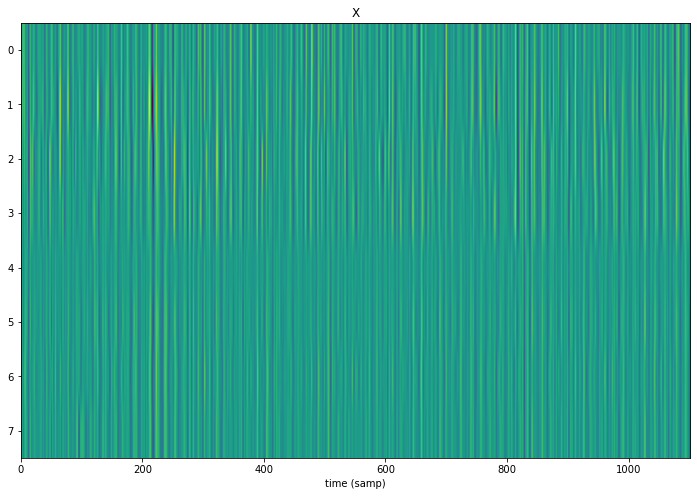

Text(0.5, 1.0, 'Y')

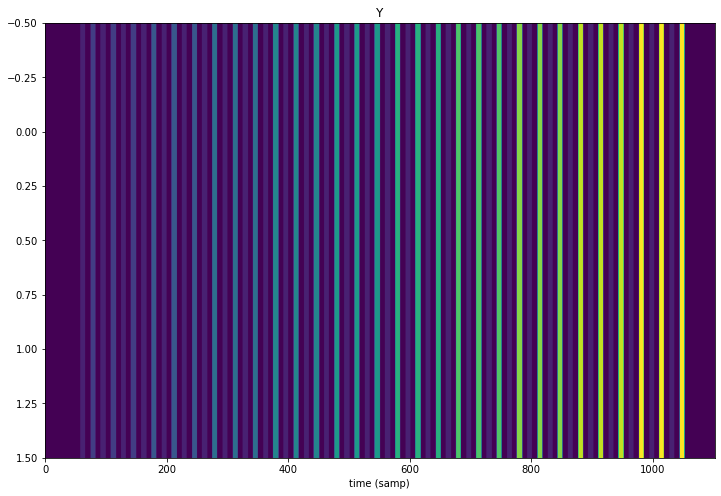

In [7]:
# output is: X=eeg, Y=stimulus, coords=meta-info about dimensions of X and Y
print("EEG: X({}){} @{}Hz".format([c['name'] for c in coords],X.shape,coords[1]['fs']))                            
print("STIMULUS: Y({}){}".format([c['name'] for c in coords[:-1]]+['output'],Y.shape))
plt.imshow(X[0,:,:].T,aspect='auto');plt.xlabel('time (samp)');plt.title('X');plt.show()
plt.imshow(Y[0,:,:].T,aspect='auto');plt.xlabel('time (samp)');plt.title('Y')

Evtlabs: ['>0', '>4', '>6', '>8']
X=(45, 1102, 8)
Y_true=(45, 1102, 1, 4)


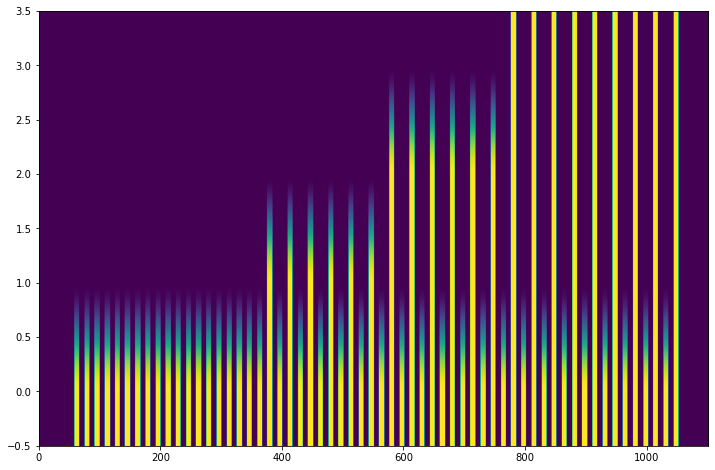

In [8]:
# get the true-label and convert to brain-response
from stim2event import stim2event
# map to event sequence, for rising/falling edges
try:
    Ye,evtlabs = stim2event(Y,evtypes=evttypes,axis=-2) # (tr,samp,nY,e)
except:
    Ye = stim2event(Y,evtypes=evttypes,axis=-2) # (tr,samp,nY,e)
    evtlabs= np.arange(Ye.shape[-1])
print("Evtlabs: {}".format(evtlabs))
# extract the true target to fit to, using horible slicing trick
Ye_true = Ye[..., 0:1, :] #  (tr,samp,1,e)
print("X={}".format(X.shape))
print("Y_true={}".format(Ye_true.shape))
plt.imshow(Ye_true[0,:,0,:].T,aspect='auto',origin='normal')

tau = 35   offset=0
Cxx=(8, 8)
Cxy=(1, 4, 35, 8)
Cyy=(1, 4, 35, 4, 35)


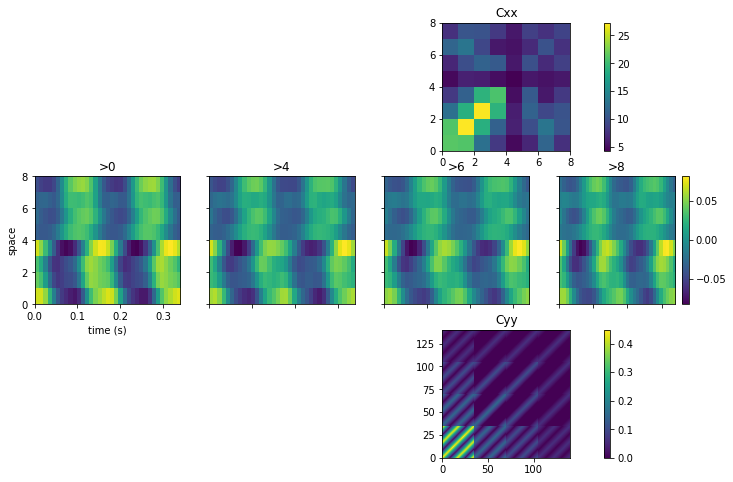

[0.44815487 0.15228876 0.10665457 0.06132285]
erp=(4, 35, 8)


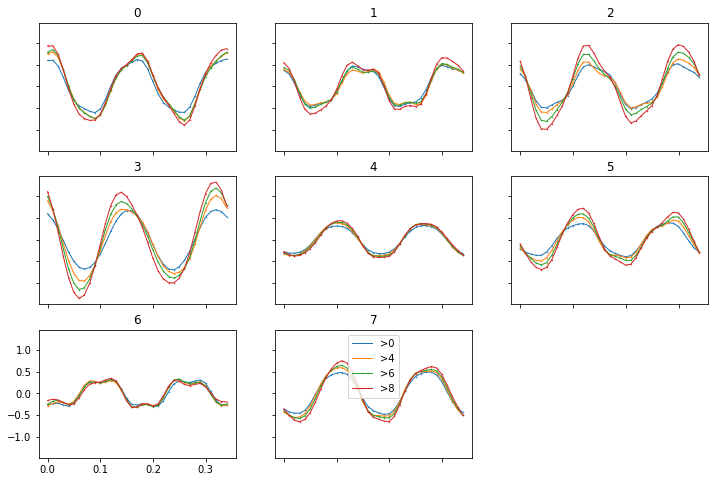

In [9]:
# get the summary statistics
from updateSummaryStatistics import updateSummaryStatistics, plot_summary_statistics, plot_erp
tau = int(tau_ms * fs // 1000) # ms->samples
offset = int(offset_ms * fs // 1000) # ms->samples
print('tau = {}   offset={}'.format(tau,offset))
Cxx, Cxy, Cyy = updateSummaryStatistics(X, Ye_true, tau=tau, offset=offset)
print("Cxx={}".format(Cxx.shape))
print("Cxy={}".format(Cxy.shape))
print("Cyy={}".format(Cyy.shape))
plot_summary_statistics(Cxx, Cxy, Cyy, evtlabs=evtlabs, fs=fs, ch_names=ch_names)
plt.show(block=False)
print(np.diag(Cyy[0,:,0,:,0]))
plot_erp(Cxy/np.diag(Cyy[0,:,0,:,0])[:,np.newaxis,np.newaxis],fs=fs,evtlabs=evtlabs,ch_names=ch_names)

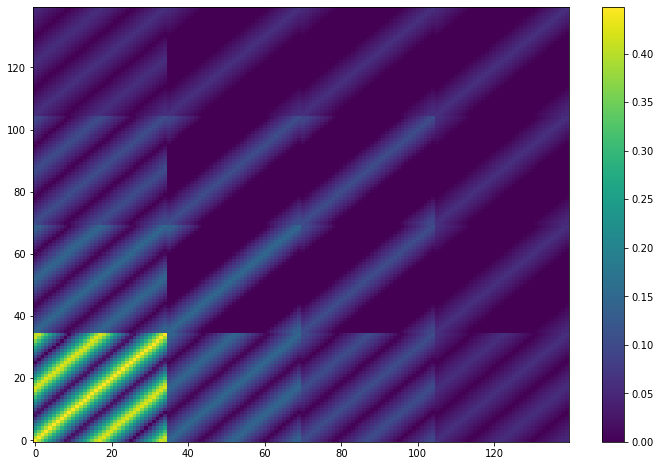

In [10]:
plt.imshow(Cyy.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto',origin='normal');plt.colorbar()

In [11]:
rank=2

A=(2, 8) R=(2, 4, 35)


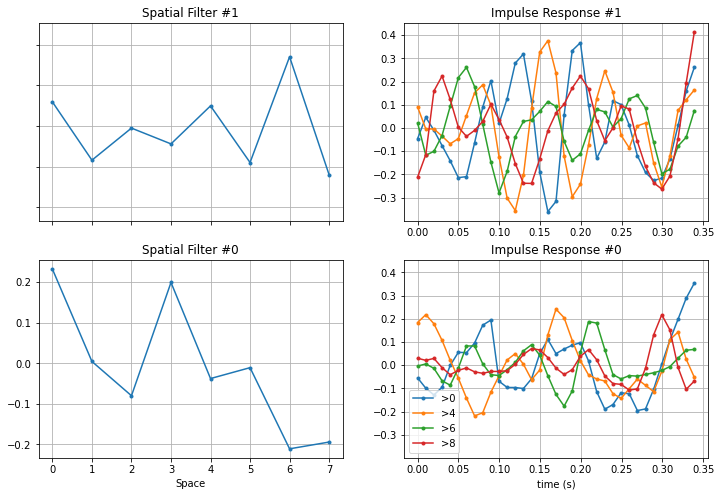

Added 30 virtual outputs
Int Lens:..............................

            IntLen   146   293   404   551   697   808   955  1102 
              Perr  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   AUDC  3.3
         Perr(est)  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   PSAE  0.4
           StopErr  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   AUSC  0.0
     StopThresh(P)  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   SSAE  0.4



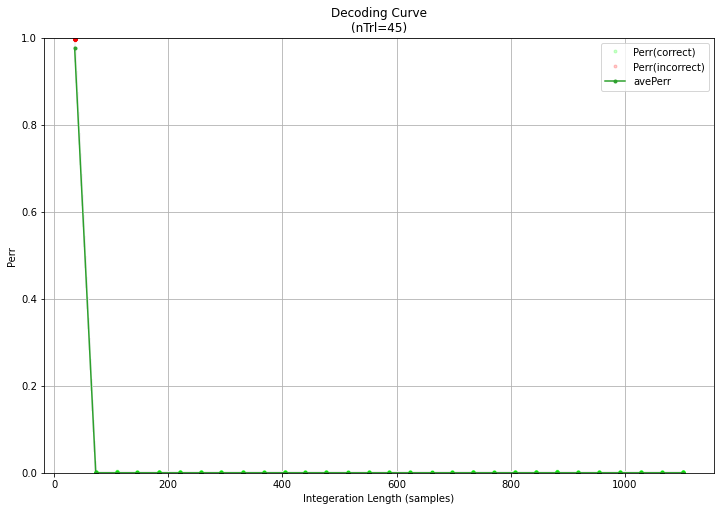

In [12]:
from multipleCCA import multipleCCA, robust_whitener
from updateSummaryStatistics import plot_factoredmodel
# run and plot the normal CCA model
J, W, R = multipleCCA(Cxx, Cxy, Cyy, reg=.02, rank=rank)
plot_factoredmodel(W, R, ch_names=ch_names, fs=fs, evtlabs=evtlabs);plt.show()
# eval this models performance
from scoreStimulus import scoreStimulus
Fe = scoreStimulus(X, W, R)
from scoreOutput import scoreOutput
Fy = scoreOutput(Fe, Ye, R=R, dedup0=True) # (nM,nTrl,nEp,nY)
from decodingCurveSupervised import decodingCurveSupervised, plot_decoding_curve
dc=decodingCurveSupervised(Fy, nvirt_out=-30)
plot_decoding_curve(*dc)

In [ ]:
# Now try with the tensor factored version..

Text(0.5, 1.0, 'Whitened: Cxx')

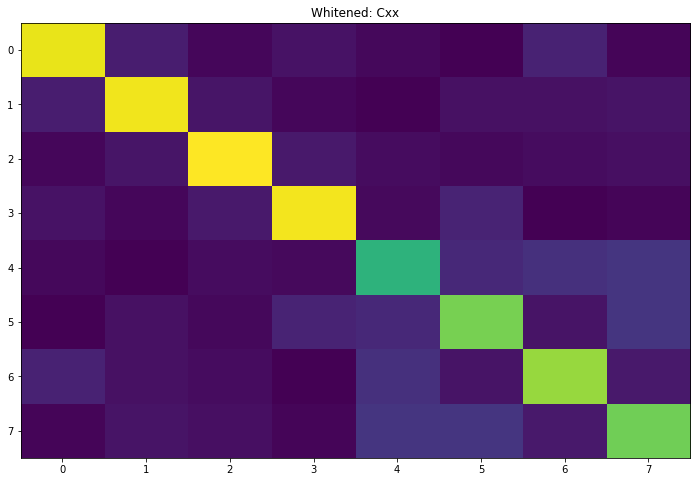

In [13]:
# 1. X spatial whitener
from multipleCCA import robust_whitener
Wx, iWx = robust_whitener(Cxx,reg=.02)

wCxxw = np.einsum("de,df,eg",Cxx,Wx,Wx)
plt.imshow(wCxxw,aspect='auto');plt.title('Whitened: Cxx')

In [14]:
# 2.Cyy combined whitener..
#  Cyy = (nM,e,tau,e,tau)
Wy, iWy = robust_whitener(Cyy.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),reg=.02) # (e*tau,e*tau)
Wy = Wy.reshape(Cyy.shape[1:]) # (e,tau,e,tau)
iWy = iWy.reshape(Cyy.shape[1:]) # (e,tau,e,tau)

In [15]:
# 2. Y temporal whitener
#  Cyy = (nM,e,tau,e,tau)
Cyy_tau = np.sum(Cyy,axis=(0,1,3))
#plt.imshow(Cyy_tau,aspect='auto');plt.title('Cyy_tau');plt.colorbar();plt.show()
Wy_tau, iWy_tau = robust_whitener(Cyy_tau,reg=.0)

#wtauCyy_tauwtau = np.einsum("tu,tv,uw",Cyy_tau,Wy_tau,Wy_tau)
#plt.imshow(wtauCyy_tauwtau,aspect='auto');plt.title('Whitended: Cyy_tau');plt.colorbar();plt.show()

#wtauCyywtau = np.einsum("metfu,tv,uw->mevfw",Cyy,Wy_tau,Wy_tau)
#plt.imshow(wtauCyywtau.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto');plt.title('Tau Whitened: Cyy')

In [16]:
# 2. Y event whitener
#  Cyy = (nM,e,tau,e,tau)
Cyy_e = np.sum(Cyy,axis=(0,2,4))
Wy_e, iWy_e = robust_whitener(Cyy_e,reg=.02)

#weCyy_ewe = np.einsum("ed,ef,dg",Cyy_e,Wy_e,Wy_e)
#plt.imshow(weCyy_ewe,aspect='auto');plt.title('Whitended: Cyy_tau');plt.show()

#wtauCyywtau = np.einsum("metfu,tv,uw->mevfw",Cyy,Wy_tau,Wy_tau)
#plt.imshow(wtauCyywtau.reshape((Cyy.shape[1]*Cyy.shape[2],-1)),aspect='auto');plt.title('Tau Whitened: Cyy')

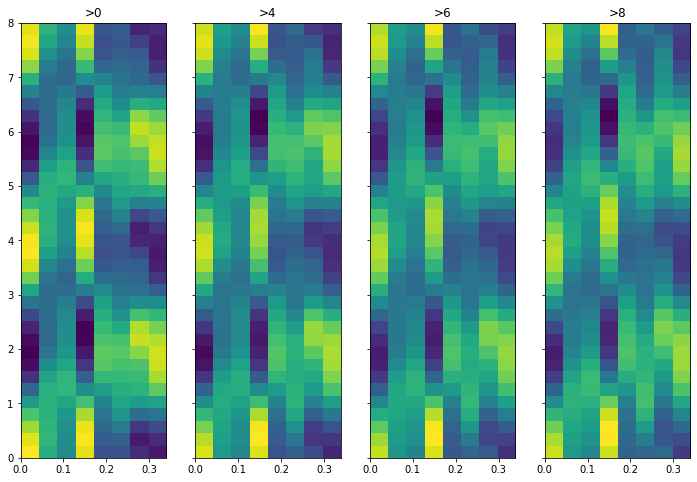

erp=(4, 35, 8)


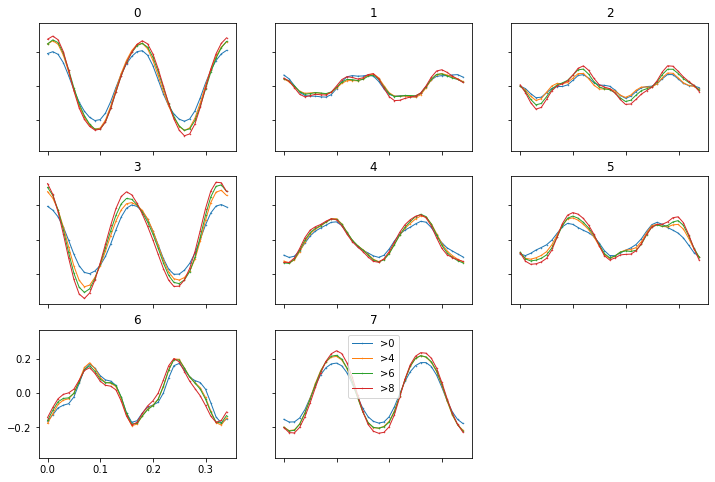

In [17]:
# apply the spatial whiteners
WxCxy = np.einsum("metd,df->metf",Cxy,Wx)
plotCxy(WxCxy,evtlabs,fs)
plt.show(block=False)
plot_erp(WxCxy/np.diag(Cyy[0,:,0,:,0])[:,np.newaxis,np.newaxis],evtlabs=evtlabs,fs=fs,ch_names=ch_names)

In [18]:
# set factored/nonfactored
isFactored = True

In [19]:
# total-temporal-whitener
if not isFactored:
    WxCxyWy_t = np.einsum("metd,etgu->mgud",WxCxy,Wy)

    print("WxCxyWy {}".format(WxCxyWy_t.shape))
    plotCxy(WxCxyWy_t,evtlabs,fs); plt.suptitle("Combined Temporal Whitened")

WxCxyWy (1, 4, 35, 8)


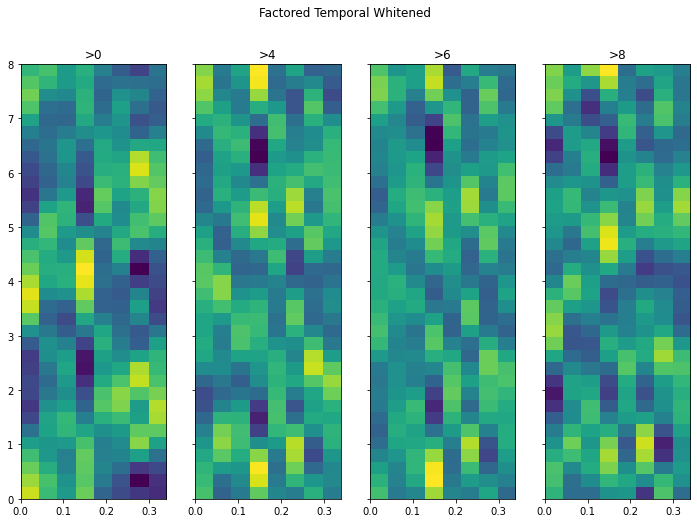

In [20]:
# factored-whitener
if isFactored:
    WxCxyWy_f = np.einsum("metd,eg,tu->mgud",WxCxy,Wy_e,Wy_tau)

    print("WxCxyWy {}".format(WxCxyWy_f.shape))
    plotCxy(WxCxyWy_f,evtlabs,fs); plt.suptitle("Factored Temporal Whitened")

ten=(4, 35, 8)


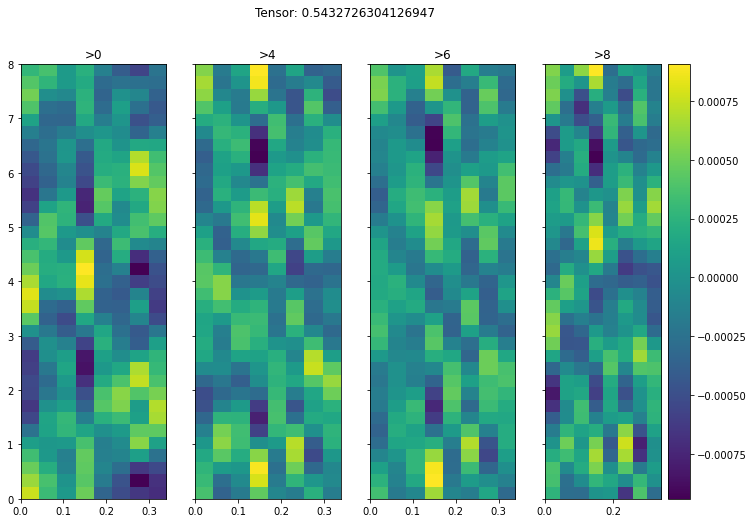

Decomp=(4, 4),(35, 4),(8, 4)
w=[1. 1. 1. 1.]
recons=(4, 35, 8)


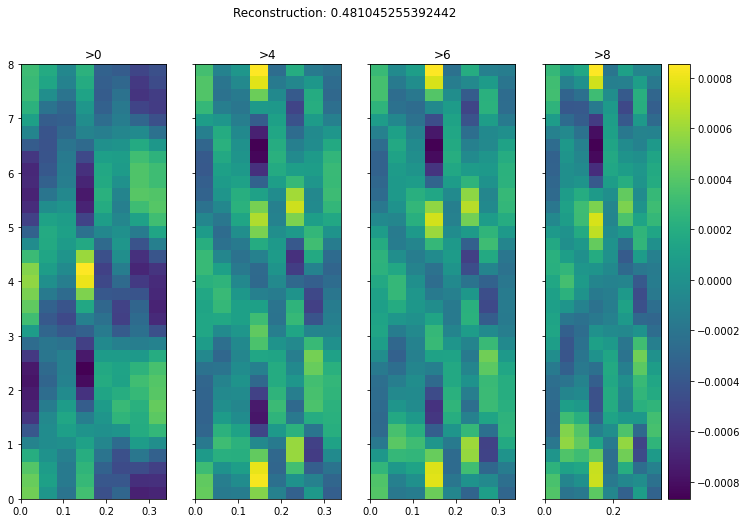

|W|=0.5432726304126947 |parafac|=0.481045255392442


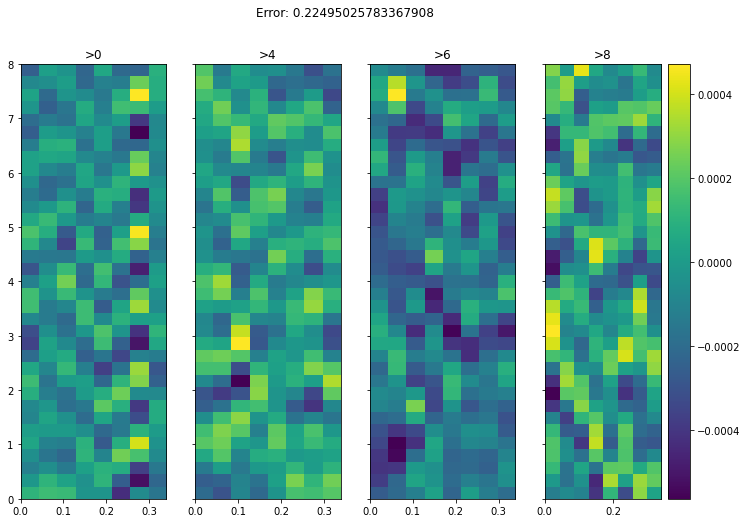

|err|=0.22495025783367908


In [23]:
# CD/PARAFAC decomp
from tensorly.decomposition import parafac
if isFactored: 
    ten = WxCxyWy_f[0,...]
else:
    ten = WxCxyWy_t[0,...]
print("ten={}".format(ten.shape))
normW = np.sum(np.abs(ten.ravel()))
plotCxy(ten[np.newaxis,...],evtlabs,fs); plt.colorbar();plt.suptitle("Tensor: {}".format(normW)); plt.show()
kruskal_decomp = parafac(ten, rank=4, normalize_factors=False, orthogonalise=True)#True)
weight = kruskal_decomp[0]
factors = kruskal_decomp[1]
print("Decomp={},{},{}".format(*[f.shape for f in factors]))
We = factors[0]
Wt = factors[1]
Wd = factors[2]
print("w={}".format(weight))

# check the reconstruction error
from tensorly import kruskal_to_tensor
recons = kruskal_to_tensor(kruskal_decomp)
normRecons = np.sum(np.abs(recons.ravel()))
print('recons={}'.format(recons.shape))
plotCxy(recons[np.newaxis,...],evtlabs,fs); plt.colorbar(); plt.suptitle("Reconstruction: {}".format(normRecons)); plt.show()
err = np.sum(np.abs(ten.ravel()-recons.ravel()))
print('|W|={} |parafac|={}'.format(normW,normRecons,err))

plotCxy((ten-recons)[np.newaxis,...],evtlabs,fs); plt.colorbar(); plt.suptitle("Error: {}".format(err)); plt.show()
print('|err|={}'.format(err))


Text(0.5, 0.98, "face_detection_210105_1403.txt evttypes=('>0', '>4', '>6', '>8')")

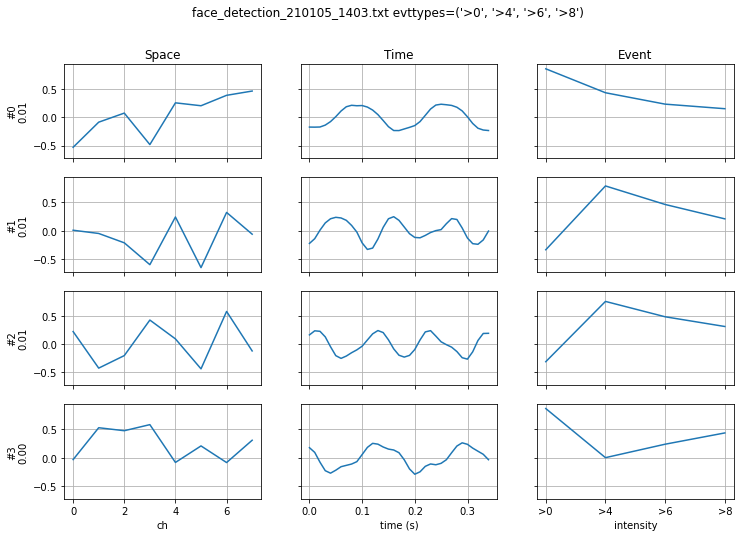

In [24]:
# plot the decomp: e,t,d x rank
ch_names = np.arange(Wd.shape[0]) if ch_names is None else ch_names
times = np.arange(Wt.shape[0])/fs
evts = evtlabs
fig, axes = plt.subplots(nrows=We.shape[1],ncols=3,sharex='col',sharey=True)
if axes.ndim<2: axes=axes[np.newaxis,:]
for r in range(We.shape[1]):
    Wer = We[:,r]; nWer = np.sqrt(np.sum(Wer**2))
    Wdr = Wd[:,r]; nWdr = np.sqrt(np.sum(Wdr**2))
    Wtr = Wt[:,r]; nWtr = np.sqrt(np.sum(Wtr**2))
    sgn = np.sign(Wer.flat[abs(Wer).argmax()]) # normalize size of the event weighting
    wght = weight[r]*nWer*nWdr*nWtr
    plt.sca(axes[r,0]); plt.plot(ch_names, Wdr/nWdr); plt.grid();  plt.ylabel('#{}\n{:3.2f}'.format(r,wght))
    if r==0: plt.title('Space');
    elif r==We.shape[1]-1: plt.xlabel('ch')
    plt.sca(axes[r,1]); plt.plot(times,    sgn*Wtr/nWtr); plt.grid(); 
    if r==0: plt.title('Time') 
    elif r==We.shape[1]-1: plt.xlabel('time (s)')
    plt.sca(axes[r,2]); plt.plot(evts,     sgn*Wer/nWer); plt.grid(); 
    if r==0: plt.title('Event')
    elif r==We.shape[1]-1: plt.xlabel('intensity') 
plt.suptitle("{} evttypes={}".format(savefile[-30:],evttypes))

In [ ]:
# make equivalent to the multiCCA outputs (so can re-use apply methods)
W = Wd.T # (rank,d)
R = np.einsum("tk,ek->ket",Wt,We) # (rank,e,tau)
plot_factoredmodel(W, R, ch_names=ch_names, fs=fs, evtlabs=evtlabs);plt.show()

In [ ]:
# apply the spatial whitener
W = W @ iWx # (d,rank)

In [ ]:
# include the temporal whitener
if isFactored:
    R = np.einsum("ket,ef,tu->kfu",R,iWy_e,iWy_tau)
else:
    R = np.einsum("ket,etfu->kfu",R,iWy)

In [ ]:
# apply to the data
from scoreStimulus import scoreStimulus
Fe = scoreStimulus(X, W, R)
from scoreOutput import scoreOutput
Fy = scoreOutput(Fe, Ye, R=R, dedup0=True) # (nM,nTrl,nEp,nY)
from decodingCurveSupervised import decodingCurveSupervised, plot_decoding_curve
dc=decodingCurveSupervised(Fy)
plot_decoding_curve(*dc)

In [ ]:
def est_matrix_variate_gaussian(X:np.ndarray,axis=(-2,-1),rcond=1e-12):
    # TODO[]: make work on Caabb directly!
    cov = [ np.eye(X.shape[i],X.shape[i]) for i in axis]
    icov = [ np.eye(X.shape[i],X.shape[i]) for i in axis]

    # build the index expressions
    sumidx = [ chr(ord('a')+i) for i in range(X.ndim)] # unique char idx 
    lsub = sumidx.copy();    rsub = sumidx.copy() 
    lsub[axis[0]]='u';       rsub[axis[0]]='v'
    lsub[axis[1]]='w';       rsub[axis[1]]='x'
    idxstr = ["{},{},{}".format("".join(lsub),'uv',"".join(rsub)),
              "{},{},{}".format("".join(lsub),'wx',"".join(rsub))]
    print('idxstrs={}'.format(idxstr))
    for iter in range(40):
        # axis[0]
        icov[0] = np.linalg.pinv(cov[0],rcond=rcond,hermitian=True)
        cov[1] = np.einsum(idxstr[0], X, icov[0], X)/X.shape[axis[0]]
        # axis[1]
        icov[1] = np.linalg.pinv(cov[1],rcond=rcond,hermitian=True)
        cov[0] = np.einsum(idxstr[1], X, icov[1], X)/X.shape[axis[1]]
        # balance norm over components
        norm = [ np.mean(np.diag(c)) for c in cov ]
        nf = np.sqrt(np.prod(norm))
        for i in range(len(cov)):
            cov[i] = cov[i] * nf / norm[i]
        # TODO[]: convergence testing   
    return cov


In [ ]:
nL=5; nR=9
L = np.random.standard_normal((1000,nL))@np.random.standard_normal((nL,nL))
R = np.random.standard_normal((1000,nR))@np.random.standard_normal((nR,nR))
X = np.einsum("il,ir->ilr",L,R)

In [ ]:
covfull = X.reshape((X.shape[0],-1)).T@X.reshape((X.shape[0],-1))
print("Full\n{}".format(covfull))
print('{}'.format(np.diag(covfull)))
plt.imshow(covfull)

In [ ]:
cov = est_matrix_variate_gaussian(X)
for i,c in enumerate(cov):
    print("{})\n {}".format(i,c))

In [ ]:
decomp = np.kron(cov[0],cov[1])
print('Decomp\n{}'.format(decomp))
print("{}".format(np.diag(decomp)))
plt.imshow(decomp);plt.colorbar()

In [ ]:
(covfull-decomp)/covfull
plt.imshow(covfull-decomp);plt.colorbar()

In [ ]:
W = [ robust_whitener(c)[0] for c in cov]

In [ ]:
Xw = np.einsum("ilr,lm,rs->ims",X,W[0],W[1])
covfullw = Xw.reshape((Xw.shape[0],-1)).T@Xw.reshape((Xw.shape[0],-1))
print("Full\n{}".format(covfullw))
print('{}'.format(np.diag(covfullw)))
plt.imshow(covfullw)